# House Prices: Advanced Regression Techniques 
In this competitions we have 79 explanatory variables describing aspects of residential homes in Ames, Iowa. The goal is to predict the prices of these houses.

The metric to calculate the accuracy of predictions is Root Mean Squared Logarithmic Error (it penalizes an under-predicted estimate greater than an over-predicted estimate).

The RMSLE is calculated as

$$
\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$

Where:



\\(\epsilon\\) is the RMSLE value (score);
\\(n\\) is the number of observations;
\\(p_i\\) is prediction;
\\(a_i\\) is the actual response for \\(i\\);
\\(\log(x)\\) is the natural logarithm of \\(x\\)

At first I explore the data, fill missing values and visualize some features, then I try several models for prediction.

1. [데이터 불러오기](#loaddata)

2. [n-gram 분석](#ngram)

3. [Data visualization](#datvis)
    
4. [Data preparation](#datprep)

5. [Model](#model)

## <a name="loaddata">데이터 불러오기</a>

In [4]:
import MeCab
import os
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline


# plt 환경설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (12,8)

def searchFiles(path):
    filelist = []
    filenames = os.listdir(path)
    for filename in filenames:
        file_path = os.path.join(path, filename)
        filelist.append(file_path)
    return filelist

# 데이터 불러오기
reviews = []
for filePath in searchFiles('/data/kaggle/topic-models/crawling/Reviews'):
    review = pd.read_csv(filePath, encoding = 'utf-8', engine='python')
    reviews.append(review)
docs = pd.concat(reviews, ignore_index = True)
docs_origin = copy.copy(docs)


## <a name="ngram">n-gram 분석</a>

In [5]:
# 토크나이저 정의
def getNVM_lemma(text):
    tokenizer = MeCab.Tagger()
    parsed = tokenizer.parse(text)
    word_tag = [w for w in parsed.split("\n")]
    pos = []
    # nouns, verb, adjective, 긍정/부정 지정사
    tags = ['NNG', 'NNP', 'VV', 'VA', 'VX', 'VCP', 'VCN'] #, 'MAG'
    for word_ in word_tag[:-2]:
        word = word_.split("\t")
        tag = word[1].split(",")
        if(len(word[0])<2):
            continue
        if(tag[-1] != "*"):
            t = tag[-1].split('/')
            if(len(t[0])>1 and ('VV' in t[1] or 'VA' in t[1] or 'VX' in t[1])):
                pos.append(t[0])
        else:
            if(tag[0] in tags):
                pos.append(word[0])
    return pos

### uni-gram 분석

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


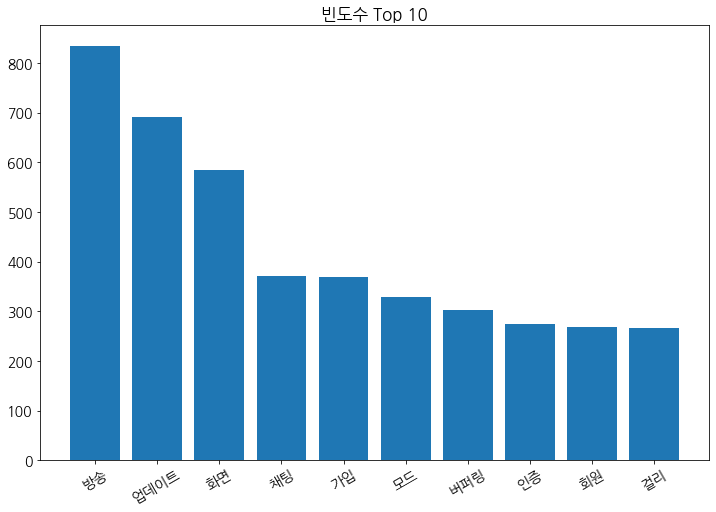

In [7]:
# uni-gram
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(1,1), min_df = 2)
dtm = tf_vect.fit_transform(docs['내용']) # 문서-단어 행렬
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()
    

words = sorted(vocab.items(), key=lambda x:x[1], reverse = True)
max_num = 10

# Remove stopwords
StopWords1 = ['게임', '너무', '나오', '생각', '만들', '많이', '정말', '아니', '진짜', '정도', '아직', '괜찮', '드리', '다시', '계속', '아프리카']
StopWords2 = ['부탁 드리', '방송 방송']
words = [item for item in words if item[0] not in StopWords1][:max_num]

plt.bar(range(max_num), [i[1] for i in words[:max_num]])
plt.title('빈도수 Top 10')
#plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max_num))
ax.set_xticklabels([i[0] for i in words[:max_num]], rotation = 30)
plt.show()

## 부정적인 피드백 분석 (평점=1)

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


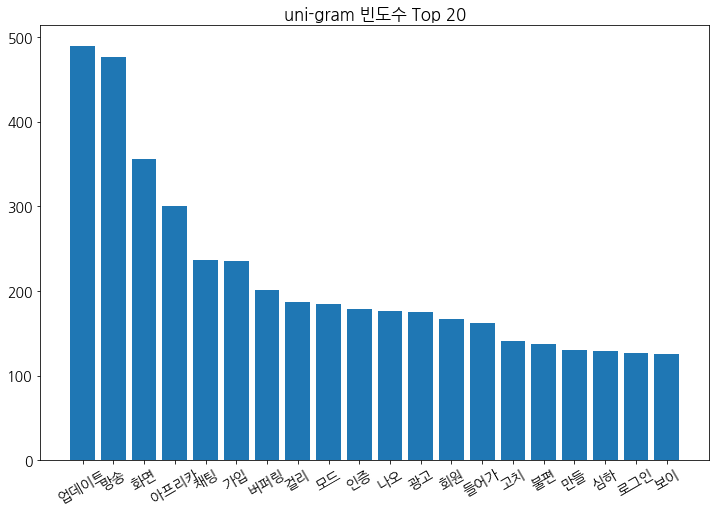

In [8]:
docs = copy.copy(docs_origin[docs_origin['평점']==1])

# uni-gram
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(1,1), min_df = 2)
dtm = tf_vect.fit_transform(docs['내용']) # 문서-단어 행렬
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()

words = sorted(vocab.items(), key=lambda x:x[1], reverse = True)
max_num = 20

# Remove stopwords
words = [item for item in words if item[0] not in StopWords2][:max_num]

plt.bar(range(max_num), [i[1] for i in words[:max_num]])
plt.title('uni-gram 빈도수 Top '+ str(max_num))
#plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max_num))
ax.set_xticklabels([i[0] for i in words[:max_num]], rotation = 30)
plt.show()

In [9]:
# 키워드별 가장 반복횟수가 많은 리뷰들
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    max_idx = np.argmax(dtm.getcol(idx).toarray())
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("반복횟수:", dtm.getcol(idx).toarray()[max_idx][0])
    print("대표리뷰:", docs['내용'].iloc[max_idx])
    print("공감수:", docs['공감수'].iloc[max_idx])
    print()

키워드: 업데이트
평점: 1
반복횟수: 5
대표리뷰: 채팅배경색만 흰바탕 검정바탕 설정 할 수 있게 다시 전처럼 바꿔주세요!! 다운그레이드 시키시면 어떻게합니까!! 이런 불만글이 한 두개도 아닌데 왜 업그레이드 할때마다 다운그레이드 시키시나요, 기존 문제되는것만 버그수정하고 업데이트하면 되지 왜 다른것도 같이 손을대서 이렇게 만드시나요. 화면비율도 업그레이드 전처럼 다시 만들어주세요. 여기서 중요한게 업데이트 할거면 할 사람만 할 수 있게 업데이트안해도 모바일로 아프리카티비 시청 할 수 있게 포맷을 바꿔주세요 업데이트하면 무조건 업데이트해야 시청 할 수 있는거 너무 싫습니다. 광고까지...
공감수: 119

키워드: 방송
평점: 1
반복횟수: 6
대표리뷰: 야한 방송,이상한 방송,폭력적인 방송 등등 엄청난 비호감 방송들이 많으며 진짜 건전한 방송은 게임방송이 끝인 아프리카 tv..여캠들은 별풍선 달라고 음란한 포즈 같은거 하고 남자들은 다 폭력적으로 미션수행. 진짜 최악
공감수: 0

키워드: 화면
평점: 1
반복횟수: 4
대표리뷰: 아니 애드벌룬 참여하기 누르면 설치화면으로 안가져요.. 3초간 화면이 안보이면서 또 몇초지나면 방송화면이 보이고;; 애드벌룬 쏠려고하는데 왜 설치화면으로 안들어가질까요 참고로 폰 최신폰입니다;;
공감수: 104

키워드: 아프리카
평점: 1
반복횟수: 5
대표리뷰: 정말 실망했습니다. 대도님 영상보고 알았는데요. 7일 정지? 정말 갑질 놀랍습니다...방송에서 욕도 안하시고,물의를 일으켰긴 하지만 그래도 열심히 하시고 그렇게 아프리카tv를 믿으셨는데.... 하다못해 윰댕님도 정지를 하시단요. 윰댕님은 아프리카tv가 처음 나왔을때 아프리카의 존재를 알리고 그렇게 하셨는데..진짜 너무하십니다. 유튜브는 광고 할때 돈이 안듭니다. 하지만 아프리카tv 당신들은 광고비 800만원이나 받았어요.이게 말이 된다고 생각해요?그리고 아프리카bj분들한테는 안받았다하지 않았나요. 저는 이제 아프리키tv와 관계를 ...
공감수: 3

키워드: 채팅
평점

In [10]:
# 해당 단어를 3번 이상 반복 & 공감수가 가장 높은 글
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    
    # 해당 단어를 3번 이상 반복
    dup_list = list((dtm.getcol(idx).toarray()>2).nonzero()[0])
    # dup_list의 공감수
    like_list = [docs['공감수'].iloc[item] for item in dup_list]
    # 공감수가 가장 높은 글
    most_idx = dup_list[np.argmax(like_list)]
    
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("반복횟수:", dtm.getcol(idx).toarray()[most_idx][0])
    print("대표리뷰:", docs['내용'].iloc[most_idx])
    print("공감수:", docs['공감수'].iloc[most_idx])
    print()

키워드: 업데이트
평점: 1
반복횟수: 4
대표리뷰: 아 진짜 짜증나는게 업데이트를 했으면, 내가 업데이트를 할지 말지 선택할 수 있는게 아닙니까? 업데이트 안하면 사용을 못하게 해버리는것은 어떤 담당자의 이상한 생각이죠? 사용자는 업데이트에 대한 선택성이 있어야 합니다. 대저 반발심부터 들게 하는 아프리카의 생각이 이해가 안가네요. 일부 독점적컨텐츠때문에 어쩔수없이 쓰던 사용자층들도 이탈하게 하겠네요.
공감수: 368

키워드: 방송
평점: 1
반복횟수: 3
대표리뷰: 제가 팬가입한 Bj방송 중에서 안보는 Bj방송들 있는데 혹시 bj분들이 아닌 제가 bj방송을 아예 안볼수있는 기능을 넣어주시거나 아님 팬가입을 해제를 할 수 있는 기능을 넣어주셨으면 합니다. 왜 bj들에게만 블랙 권한은 있고, 팬가입한 분들한테는 그러한 기능이 없는지 이해가 안됩니다. 제가 리뷰 올린 기능들을 추가해주셨으면 합니다. 아프리카tv게시글에 올리면 그러한 부분은 안된다고 하시니까 이렇게 리뷰로 남깁니다.
공감수: 441

키워드: 화면
평점: 1
반복횟수: 3
대표리뷰: 업데이트 너무 다운그레이드 된거같아요. 화면비율 4대3 이랑 16대9 선택할수 있던거 왜 없어졌나요 화면작아서 눈아파요. 모바일로 보지말라는 업데이트인지; 왜점점 어플이 안좋아지는지 이해가안되네요.. 이번에는 아예 채팅창 배경도 다크모드 안하면 계속 흰색이네요. 채팅창만 검정색으로 배경설정하는 기능 다시 넣어주세요; 화면은 작아지고 배경은 흰색되고 계속 보기불편해짐 눈아파요
공감수: 711

키워드: 아프리카
평점: 1
반복횟수: 3
대표리뷰: 오늘 저녁부터 아프리카를 틀어보니까 서버에 접속할수 없다는 창이 뜨네요... 제 폰에 문제가 있나 싶어 전원을 다시 껏다 켜도 안되고 아프리카를 지우고 다시 깔아도 계속그러고 와이파이와 데이터에 문제도 전혀없습니다. 몇번을 그렇게 반복해도 그 창이 뜨는데 제 폰이 이상한건가요? 아니면 아프리카에 문제가 있는건가요?
공감수: 54

키워드: 채팅
평점: 1
반복횟수: 4
대표리

## 긍정적인 피드백 분석 (평점 3이상)

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


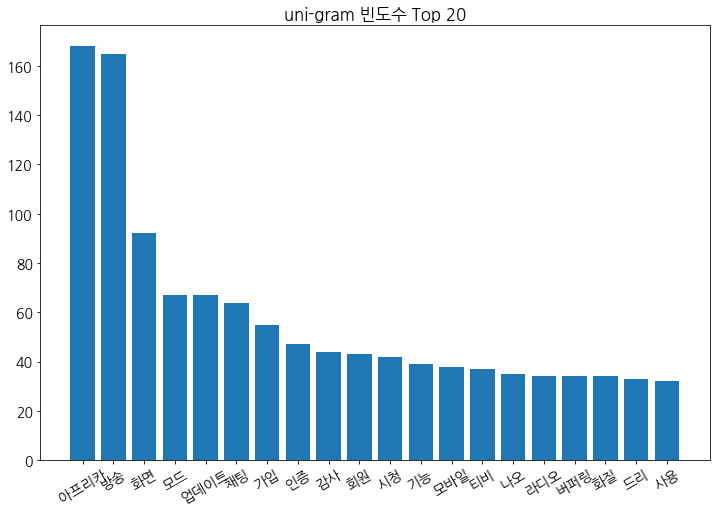

In [11]:
docs = copy.copy(docs_origin[docs_origin['평점']>3])

# uni-gram
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(1,1), min_df = 2)
dtm = tf_vect.fit_transform(docs['내용']) # 문서-단어 행렬
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()

words = sorted(vocab.items(), key=lambda x:x[1], reverse = True)
max_num = 20

# Remove stopwords
words = [item for item in words if item[0] not in StopWords2][:max_num]

plt.bar(range(max_num), [i[1] for i in words[:max_num]])
plt.title('uni-gram 빈도수 Top '+ str(max_num))
#plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max_num))
ax.set_xticklabels([i[0] for i in words[:max_num]], rotation = 30)
plt.show()

In [12]:
# 키워드별 가장 반복횟수가 높은 리뷰들
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    max_idx = np.argmax(dtm.getcol(idx).toarray())
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("반복횟수:", dtm.getcol(idx).toarray()[max_idx][0])
    print("대표리뷰:", docs['내용'].iloc[max_idx])
    print("공감수:", docs['공감수'].iloc[max_idx])
    print()

키워드: 아프리카
평점: 4
반복횟수: 4
대표리뷰: 여러분 참고로 아프리카tv는 월래 14미만이상이어야합니다 그이유는 아프리카tv는 어른이나 중학생 고등학생 방송하는거고 또한 않좋은욕설이나 그런게 나와서입니다 그리고 아프리카tv 플레이스토어에서 보면3세라고 뜨는이유는 당연히 18세면 성인인증 해야만하고 초딩분들은 불편하고 보고싶은분들도있으니까 그냥 풀어논거져.. 그래서 아프리카tv는 어리신분들은 관전만하라는거에요
공감수: 2

키워드: 방송
평점: 5
반복횟수: 4
대표리뷰: 이 개인방송 플랫폼이 세계의 버금가는 플랫폼으로 성장했으면 좋겠습니다. 국뽕에 취해보고 싶네요. 최근 업데이트로 VOD 시스템이 정돈 되어 자신이 자주보는 BJ의 다시보기를 방송국에 직접 들어가지 않고도 볼 수 있게 되었으며 인기 방송, 신입 방송, 컨텐츠별 인기, 신입 방송도 나누어져 있어 더욱 찾아보기 쉽죠. 게다가 블리자드 게임들 대회를 열어 게이머와 그 게임의 팬에게 많은 재미를 재공하고 있죠. 인기 종목, 비인기 종목 가릴 것 없이 볼 수 있어 너무 좋습니다.
공감수: 304

키워드: 화면
평점: 4
반복횟수: 7
대표리뷰: 이번 업데이트 된 거 다 좋은데요. 세로 화면일 때 4대3 비율로 보면 전체화면으로 볼 때도 4대3 비율이어서 화면이 잘려서 일일이 바꿔야 하는게 불편하네요. 옛날에는 세로화면에서 전체화면(지금의 4대3)이어도 가로 전체화면으로 바꾸면 그냥 전체화면이었거든요. 예전처럼 바꿔주세요
공감수: 8

키워드: 모드
평점: 4
반복횟수: 5
대표리뷰: 1. 라디오모드가 안풀립니다. 라디오모드 상태에서 상태바 내려서 터치하면 원래 방송모드로 바뀌었는데 계속 라디오모드이고 강제종료 후에 다시 방송에 들어가도 라디오모드가 기본값이 되어서 계속 반복 됩니다. 2.앱을 지우고 다시 깔았을때 첫 알림받기를 거절을 누르면 이후에 다시 즐찾알림받기를 설정해도 알림이 안옵니다. 결국 다시 지웠다가 설치해서 알림 받기 눌렀습니다. 초창기보다 오류가 갈수록 많아지네요 1번,2번 답변

In [13]:
# 해당 단어를 3번 이상 반복 & 공감수가 가장 높은 글
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    
    # 해당 단어를 3번 이상 반복
    dup_list = list((dtm.getcol(idx).toarray()>2).nonzero()[0])
    if len(dup_list)==0:
        dup_list = list((dtm.getcol(idx).toarray()>0).nonzero()[0])
    
    # dup_list의 공감수
    like_list = [docs['공감수'].iloc[item] for item in dup_list]
    # 공감수가 가장 높은 글
    most_idx = dup_list[np.argmax(like_list)]
    
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("반복횟수:", dtm.getcol(idx).toarray()[most_idx][0])
    print("대표리뷰:", docs['내용'].iloc[most_idx])
    print("공감수:", docs['공감수'].iloc[most_idx])
    print()

키워드: 아프리카
평점: 5
반복횟수: 4
대표리뷰: 여러분 참고로 아프리카tv는 월래 14미만이상이어야합니다 그이유는 아프리카tv는 어른이나 중학생 고등학생 방송하는거고 또한 않좋은욕설이나 그런게 나와서입니다 그리고 아프리카tv 플레이스토어에서 보면3세라고 뜨는이유는 당연히 18세면 성인인증 해야만하고 초딩분들은 불편하고 보고싶은분들도있으니까 그냥 풀어논거져.. 그래서 아프리카tv는 어리신분들은 관전만하라는거에요
공감수: 2

키워드: 방송
평점: 5
반복횟수: 4
대표리뷰: 이 개인방송 플랫폼이 세계의 버금가는 플랫폼으로 성장했으면 좋겠습니다. 국뽕에 취해보고 싶네요. 최근 업데이트로 VOD 시스템이 정돈 되어 자신이 자주보는 BJ의 다시보기를 방송국에 직접 들어가지 않고도 볼 수 있게 되었으며 인기 방송, 신입 방송, 컨텐츠별 인기, 신입 방송도 나누어져 있어 더욱 찾아보기 쉽죠. 게다가 블리자드 게임들 대회를 열어 게이머와 그 게임의 팬에게 많은 재미를 재공하고 있죠. 인기 종목, 비인기 종목 가릴 것 없이 볼 수 있어 너무 좋습니다.
공감수: 304

키워드: 화면
평점: 5
반복횟수: 4
대표리뷰: 실내 PC환경의 경우 좌우반전 화면 사용하지 않지만 핸드폰 방송일경우 비제이의 편의를 위해 좌우반전된 화면을 접합니다. 시청자가 화면을 좌우 반전 시켜 옳은 화면 시청이 가능 하다면 좋을듯 합니다.
공감수: 184

키워드: 모드
평점: 5
반복횟수: 3
대표리뷰: 저는 게임을 하면서 아프리카 창모드를 많이 사용합니다. 자동사냥을 할 때는 창 크기를 크게 해서 볼 때가 많아요. 이번 업데이트에서는 가로화면의 창모드 최대 크기가 많이 작아졌네요. 예전처럼 가로화면의 창모드 크기 제한을 늘려주세요!!
공감수: 14

키워드: 업데이트
평점: 5
반복횟수: 3
대표리뷰: 좋긴좋은데 업데이트를 한번하게되면잘안되는게그건왜그런건가요 한번에 업데이트 되게좀 해주세요 그리고 업데이트 할려고하고 설치할수없다고에러가 뜨고다시설치해야되고 너무한거아닙니까 빨리해결해주세요
공감

## bi-gram 분석

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


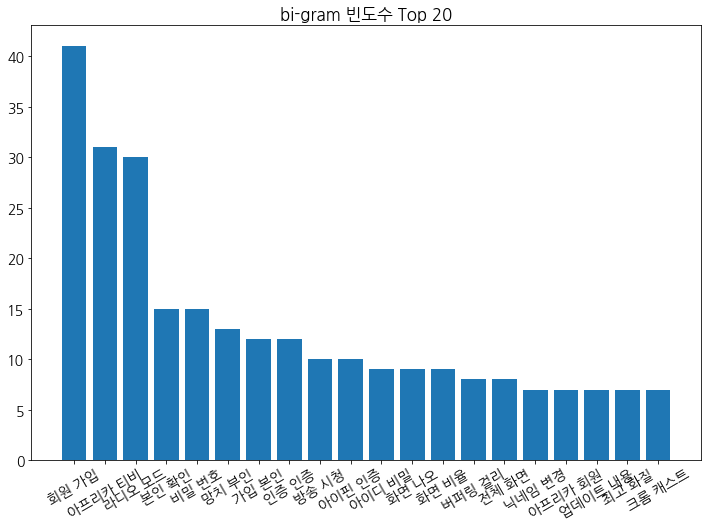

In [14]:
# bi-gram
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(2,2), min_df = 2)
dtm = tf_vect.fit_transform(docs['내용']) # 문서-단어 행렬
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()

words = sorted(vocab.items(), key=lambda x:x[1], reverse = True)
max_num = 20

# Remove stopwords
words = [item for item in words if item[0] not in StopWords2][:max_num]

plt.bar(range(max_num), [i[1] for i in words[:max_num]])
plt.title('bi-gram 빈도수 Top '+ str(max_num))
#plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max_num))
ax.set_xticklabels([i[0] for i in words[:max_num]], rotation = 30)
plt.show()

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


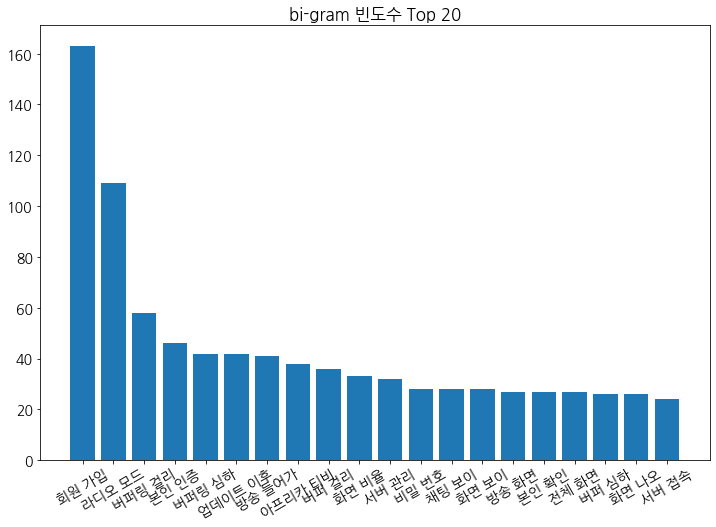

In [15]:
docs = copy.copy(docs_origin[docs_origin['평점']==1])

# bi-gram
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(2,2), min_df = 2)
dtm = tf_vect.fit_transform(docs['내용']) # 문서-단어 행렬
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()

words = sorted(vocab.items(), key=lambda x:x[1], reverse = True)
max_num = 20

# Remove stopwords
words = [item for item in words if item[0] not in StopWords2][:max_num]

plt.bar(range(max_num), [i[1] for i in words[:max_num]])
plt.title('bi-gram 빈도수 Top '+ str(max_num))
#plt.xlabel('단어')
ax = plt.subplot()
ax.set_xticks(range(max_num))
ax.set_xticklabels([i[0] for i in words[:max_num]], rotation = 30)
plt.show()

In [16]:
# 키워드별 가장 반복횟수가 많은 리뷰들
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    max_idx = np.argmax(dtm.getcol(idx).toarray())
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("공감수:", docs['공감수'].iloc[max_idx])
    print("반복횟수:", dtm.getcol(idx).toarray()[max_idx][0])
    print("대표리뷰:", docs['내용'].iloc[max_idx])
    print()

키워드: 회원 가입
평점: 1
공감수: 19
반복횟수: 4
대표리뷰: 진짜 답이 없다...별점 1점도 주기 아까운 수준이다.. 방송보다가 즐겨찾기 좀 하려고 별 눌렀는데 로그인하래서 회원가입 다 하고 로그인 했는데 "등록되지 않은 아이디 뭐라뭐라"이래서 회원가입할때 비밀번호를 잘못눌렀나 싶어서 비밀번호 찾기 가서 비밀번호 바꾸고 다시 로그인 했는데 안되서혹시 회원가입이 안된건가 하고 회원가입 다시할려고 보니까 "사용중인 아이디입니다" 참나 어이가 없어서 리뷰 남기네요..제 비밀번호는 대체 누가 설정하는거죠? 분명 제가 설정한 비밀번호는 어디가고 제아이디를 대체 누가 쓴다는 겁니까 진짜 어이가없네;; ...

키워드: 라디오 모드
평점: 1
공감수: 1
반복횟수: 5
대표리뷰: 라디오 모드로 시청 중 네트워크 연결이 끊기고 다시 연결 된 뒤 방송 시청 시 라디오 모드로 바로 전환되고 라디오 모드를 꺼도 않돼서 전원을 껐다 키고 아프리카도 재접속 했는데도 라디오 모드로 계속 전환되고 라디오 모드를 꺼도 화면이 까맣게 나옵니다..

키워드: 버퍼링 걸리
평점: 1
공감수: 12
반복횟수: 2
대표리뷰: 언제부터인지 정확하게는 모르겠지만 아마 4월 말? 5월 초부터 와이파이로 시청할때 신호세기 130Mbps 나오는데 라이브 방송에서 거의 20초? 마다 버퍼링 걸리네요 동영상 클립 볼 때는 또 괜찮은듯..? 예전에는 이런 적이 한번도 없었는데 요즘 너무 심해져서 글 올립니당. 초고화질, 고화질 모든 방송 같은 증상 있습니다. 실험해보니까 LTE환경에서는 아무 문제 없는데 데이터 다 쓸 수는 없습니다.. 와이파이망 사용할 때 버퍼링 걸리는거 하루 빨리 고쳐주세요..

키워드: 본인 인증
평점: 1
공감수: 0
반복횟수: 3
대표리뷰: 정말 망했으면 좋겠네요^^ 유튜브로 보다가 좋아하는 스트리머 생방송 보려고 다운받아 가입하려는데 휴대폰본인인증을 하고 다음을 누르니 다시 아이디.비번등을 설정하는 화면이되고 또 뭐지하면서 다입력한 후 또 본인인증했하고 본인인증 완료됬다고 떠

In [17]:
# 해당 단어를 3번 이상 반복 & 공감수가 가장 높은 글
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    
    # 해당 단어를 2번 이상 반복
    dup_list = list((dtm.getcol(idx).toarray()>1).nonzero()[0])
    if len(dup_list)==0:
        dup_list = list((dtm.getcol(idx).toarray()>0).nonzero()[0])
    
    # dup_list의 공감수
    like_list = [docs['공감수'].iloc[item] for item in dup_list]
    # 공감수가 가장 높은 글
    most_idx = dup_list[np.argmax(like_list)]
    
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("공감수:", docs['공감수'].iloc[most_idx])
    print("반복횟수:", dtm.getcol(idx).toarray()[most_idx][0])
    print("대표리뷰:", docs['내용'].iloc[most_idx])

    print()

키워드: 회원 가입
평점: 1
공감수: 91
반복횟수: 2
대표리뷰: 아니 회원가입할때 실제로 있는 이메일인데... 계속 올바른 형식 이메일이 올바르지 않다고 하면서 계속 다시확인 해달라고 하자나요... 그러니까 회원가입이 안돼서 기분이 않좋아요... 제이메일은 sji4111@outlook인데 지짜않돼잔아요 페치해주세요!!!!! 꼭

키워드: 라디오 모드
평점: 1
공감수: 17
반복횟수: 2
대표리뷰: 뭔가를 만들기 전에 팝업했을 때 튕기거나 버퍼링 걸리는 오류, 라디오 모드를 했을 때 걸리는 멈춤 현상부터 어떻게 고치셔야한다고 봅니다. 처음엔 그러려니 했는데 이게 한 두번도 아니고 튕김 현상과 멈춤 현상이 짧으면 1분(더 짧은 적도 있고), 길면 5분에서 10분 가량이에요. 라디오모드에서 멈추는 현상도 그정도 하구요. 좋아하는 BJ분이 계셔서 보는데 아프리카TV 진짜 점점 갈수록 정 떨어집니다.. 뭔가를 고치려고 하면 오류만 생기고.. 지금 쓰는 도중에도 팝업 틀어놓고 있는데 2번은 튕겼습니다. 이정도면 진짜 문제 있다고 보네요...

키워드: 버퍼링 걸리
평점: 1
공감수: 39
반복횟수: 2
대표리뷰: 아니무슨 갑자기 버퍼링이 5초마다걸려서 볼수가없어요 와이파이문제 절대아니고 지금 제폰 둘다안됩니다 "면역 떨어지고"광고만 엄청 봤네요 광고는 왜 버퍼링 안걸리죠?

키워드: 본인 인증
평점: 1
공감수: 16
반복횟수: 3
대표리뷰: 19세 본인 인증이 왜 이렇게 안되나요. 점검 좀 해주세요. 그리구 본인인증 시스템 구축하고 한번 시험사용은 하는것인가요? 답변문항 입력하는데 디테일이 너무 떨어지네요. 한번 확인 하면 이렇지는 않을것 같은데, ex보안인증문자 검색시 한글자판 그대로 있는점, 본인인증번호 입력 한글자판 그대로 있는점 거   멘

키워드: 버퍼링 심하
평점: 1
공감수: 110
반복횟수: 2
대표리뷰: 버퍼링이 너무 심합니다. 몇 주 전부터 버퍼링이 너무 심합니다. 못 볼 정도로.. 갑자기 심해진거 보니까 폰 때문은 아닌거 같은데 리뷰를 보니까

## 긍정적인 피드백 분석 (평점 >3)

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


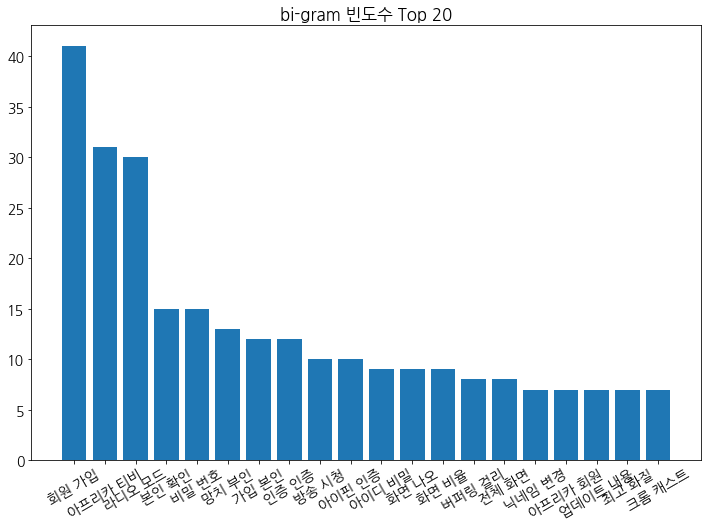

In [18]:
docs = copy.copy(docs_origin[docs_origin['평점']>3])

# uni-gram
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(2,2), min_df = 2)
dtm = tf_vect.fit_transform(docs['내용']) # 문서-단어 행렬
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()

words = sorted(vocab.items(), key=lambda x:x[1], reverse = True)
max_num = 20

# bi-gram
tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(2,2), min_df = 2)
dtm = tf_vect.fit_transform(docs['내용']) # 문서-단어 행렬
vocab = dict()
for idx, word in enumerate(tf_vect.get_feature_names()):
    vocab[word] = dtm.getcol(idx).sum()

words = sorted(vocab.items(), key=lambda x:x[1], reverse = True)
max_num = 20

# Remove stopwords
words = [item for item in words if item[0] not in StopWords2][:max_num]

plt.bar(range(max_num), [i[1] for i in words[:max_num]])
plt.title('bi-gram 빈도수 Top '+ str(max_num))
ax = plt.subplot()
ax.set_xticks(range(max_num))
ax.set_xticklabels([i[0] for i in words[:max_num]], rotation = 30)
plt.show()

In [19]:
# 키워드별 가장 반복횟수가 많은 리뷰들
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    max_idx = np.argmax(dtm.getcol(idx).toarray())
    print("(대표리뷰)")
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("공감수:", docs['공감수'].iloc[max_idx])
    print("반복횟수:", dtm.getcol(idx).toarray()[max_idx][0])
    print("내용:", docs['내용'].iloc[max_idx])
    print()

(대표리뷰)
키워드: 회원 가입
평점: 5
공감수: 4
반복횟수: 3
내용: 안녕하세요! 제가 아프리카 티비를 이제 사용하려고 합니다. 그래서 댓글도 달려고 하는데 제가 핸드폰이 제 명의가 아니고 핸드폰 회원가입이 좀 어려워서 이메일로 회원가입 할 수 있으면 좋겠습니다! 부탁드립니다!모바일로 이메일 회원가입 가능하게 해주세요! 그거 빼곤 다 좋습니다!!최고예요! 게임방송,이런거 보기 최고 입니다! 운영자님!꼭 좀 부탁드려요!! 부탁드립니다!!진짜요!!

(대표리뷰)
키워드: 아프리카 티비
평점: 4
공감수: 222
반복횟수: 2
내용: 정말 재밌게 방송 잘 보고 있는 유저입니다 하지만 아프리카티비의 중계방이라는 시스템은 정말 이해할 수가 없어서 이렇게 리뷰에 적습니다. 우선 중계방과 본방의 개별화로 BJ는 본방의 채팅만 볼 수 있어서 채팅의 질을 조금이라도 올리려는 의도는 이해합니다만 이 장점이 단점이 되어 중계방에서 시청해야 하는 일반 선한 시청자들이 온갖 지역 차별과 도배, 그리고 성적인 발언, 시청자간의 말싸움까지 보고 있어야 한다는 것이 아프리카티비의 치명적인 단점이라고 생각합니다. 그리고 저런 좋지 않은 채팅을 쓰는 사람들이 있다면 본방에서처럼 BJ가 직...

(대표리뷰)
키워드: 라디오 모드
평점: 4
공감수: 5
반복횟수: 4
내용: 1. 라디오모드가 안풀립니다. 라디오모드 상태에서 상태바 내려서 터치하면 원래 방송모드로 바뀌었는데 계속 라디오모드이고 강제종료 후에 다시 방송에 들어가도 라디오모드가 기본값이 되어서 계속 반복 됩니다. 2.앱을 지우고 다시 깔았을때 첫 알림받기를 거절을 누르면 이후에 다시 즐찾알림받기를 설정해도 알림이 안옵니다. 결국 다시 지웠다가 설치해서 알림 받기 눌렀습니다. 초창기보다 오류가 갈수록 많아지네요 1번,2번 답변처럼 변경하니 좋아졌습니다

(대표리뷰)
키워드: 본인 확인
평점: 5
공감수: 0
반복횟수: 3
내용: 아프리카 TV 점부다 좋은데 아프리카TV 회원가입 하려는데 본인확인 에서 본인확인 하면 빨간색으로 

In [20]:
# 해당 단어를 3번 이상 반복 & 공감수가 가장 높은 글
for word in words[:max_num]:
    word = word[0]
    word_list = tf_vect.get_feature_names()
    idx = word_list.index(word)
    
    # 해당 단어를 2번 이상 반복
    dup_list = list((dtm.getcol(idx).toarray()>1).nonzero()[0])
    if len(dup_list)==0:
        dup_list = list((dtm.getcol(idx).toarray()>0).nonzero()[0])
    
    # dup_list의 공감수
    like_list = [docs['공감수'].iloc[item] for item in dup_list]
    # 공감수가 가장 높은 글
    most_idx = dup_list[np.argmax(like_list)]
    
    print("(대표리뷰)")
    print("키워드:", tf_vect.get_feature_names()[idx])
    print("평점:", int(docs['평점'].iloc[max_idx]))
    print("공감수:", docs['공감수'].iloc[most_idx])
    print("반복횟수:", dtm.getcol(idx).toarray()[most_idx][0])
    print("내용:", docs['내용'].iloc[most_idx])

    print()

(대표리뷰)
키워드: 회원 가입
평점: 5
공감수: 6
반복횟수: 2
내용: 아니 회원가입을 몇번이나 했는데 왜 아이디 비번 맞게 쳤는데 왜 가입이 안되죠? 참.. 이상하네요 하 빨리 실시간 보고싶은데 회원가입 이 안되잖아요! 일똑바로 해요!당신들!

(대표리뷰)
키워드: 아프리카 티비
평점: 5
공감수: 222
반복횟수: 2
내용: 정말 재밌게 방송 잘 보고 있는 유저입니다 하지만 아프리카티비의 중계방이라는 시스템은 정말 이해할 수가 없어서 이렇게 리뷰에 적습니다. 우선 중계방과 본방의 개별화로 BJ는 본방의 채팅만 볼 수 있어서 채팅의 질을 조금이라도 올리려는 의도는 이해합니다만 이 장점이 단점이 되어 중계방에서 시청해야 하는 일반 선한 시청자들이 온갖 지역 차별과 도배, 그리고 성적인 발언, 시청자간의 말싸움까지 보고 있어야 한다는 것이 아프리카티비의 치명적인 단점이라고 생각합니다. 그리고 저런 좋지 않은 채팅을 쓰는 사람들이 있다면 본방에서처럼 BJ가 직...

(대표리뷰)
키워드: 라디오 모드
평점: 5
공감수: 5
반복횟수: 4
내용: 1. 라디오모드가 안풀립니다. 라디오모드 상태에서 상태바 내려서 터치하면 원래 방송모드로 바뀌었는데 계속 라디오모드이고 강제종료 후에 다시 방송에 들어가도 라디오모드가 기본값이 되어서 계속 반복 됩니다. 2.앱을 지우고 다시 깔았을때 첫 알림받기를 거절을 누르면 이후에 다시 즐찾알림받기를 설정해도 알림이 안옵니다. 결국 다시 지웠다가 설치해서 알림 받기 눌렀습니다. 초창기보다 오류가 갈수록 많아지네요 1번,2번 답변처럼 변경하니 좋아졌습니다

(대표리뷰)
키워드: 본인 확인
평점: 5
공감수: 3
반복횟수: 2
내용: 구글회원가입,아프리카TV회원가입 본인확인아이디 비밀번호 2차 비밀번호 이메일주소 이름 년/월/일 이미지사진을찍었습니다 김혜림님전화상담을왔습니다 닉네임변경/아이디/본인확인이미지입니다

(대표리뷰)
키워드: 비밀 번호
평점: 5
공감수: 74
반복횟수: 2
내용: 개발자님대표이사님운영자님클린이티님아프리카TV

## Latent Dirichlet Allocation

In [36]:
import joblib

from sklearn.decomposition import LatentDirichletAllocation

reviews = []

for filePath in searchFiles('/data/kaggle/topic-models/crawling/Reviews'):
    review = pd.read_csv(filePath, encoding = 'utf-8', engine='python')
    reviews.append(review)

# LDA: try 2
docs = pd.concat(reviews, ignore_index = True)
docs = docs[docs['평점']>3]
docs = docs.reset_index(drop=True)
docs['내용'] = docs.apply(lambda x: x['내용']*int(np.log2(2+x['공감수'])), axis=1)

#tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(1, 2), min_df = 2, max_df = 6000,
#                          max_features= 25000)

tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(1, 2), min_df = 2, max_df = 6000,
                          max_features= 25000)

dtm = tf_vect.fit_transform(docs['내용'])
n_topics = 18 # 18
lda = LatentDirichletAllocation(n_components=n_topics, topic_word_prior=0.01, doc_topic_prior=0.01)
tdm = lda.fit(dtm)
saved_model = joblib.dump(tdm, 'LDA.pkl')

names = tf_vect.get_feature_names()
topics_word = dict()

# 주제에 포함된 단어 갯수
n_words = 10 #20
# 주제에 속한 단어 topics_word에 저장
# 공감수 5이상인 것만 고려
likemore = list(np.where(docs['공감수']>4)[0])
#for idx, topic in enumerate(lda.components_[:, like5]):
for idx, topic in enumerate(lda.components_):
    vocab = []
    for i in topic.argsort()[:-(n_words-1):-1]:
        vocab.append((names[i], topic[i].round(2)))
    topics_word[idx+1] = [(names[i], topic[i].round(2)) for i in topic.argsort()[:-(n_words-1):-1]]
    
# 주제당 가장 큰 비중을 차지하는 리뷰 출력
max_dict = dict()
for idx, vec in enumerate(lda.transform(dtm)):
    # 공감수 5이하는 제외
    if idx not in likemore:
        pass
    t = vec.argmax()
    if (t not in max_dict) and vec[t]>0.97:
        max_dict[t] = ([vec[t]], [idx])
    else:
        #if max_dict[t][0] < vec[t]:
        #    max_dict[t] = (vec[t], idx)
        if vec[t] > 0.97:
            max_dict[t] = (max_dict[t][0] + [vec[t]], max_dict[t][1] + [idx])


In [37]:
sorted_review = sorted(max_dict.items(), key = lambda x: x[0], reverse = False)

docs = pd.concat(reviews, ignore_index = True)
docs = docs[docs['평점']>3]
docs = docs.reset_index(drop=True)

for key, value_list in sorted_review:
    print('주제 {}: {}'.format(key+1, topics_word[key+1]))
    for i in range(min(4, len(value_list[0]))):
        print('[주제 {}의 대표 리뷰 :{}]\n{}\n'.format(key+1, value_list[0][i], docs['내용'][value_list[1][i]]))

주제 1: [('모바일', 37.94), ('방송', 26.09), ('로그인', 23.83), ('고치', 22.01), ('시청', 16.82), ('만들', 16.1), ('목록', 14.41), ('아프리카', 12.58)]
[주제 1의 대표 리뷰 :0.9971274079080771]
아프리카를 67년 봤는데 요번패치 이후로 처음으로 모바일 고화질영상에서 자꾸 끊기네요 이것만 고쳐주시면 앞으로도 계속 재밌게 볼 수 있을것같네요.

[주제 1의 대표 리뷰 :0.9906490649064902]
이번 업뎃하고 모바일데이터 사용하고 방들어가면 최고화질 기본설정 없어진건가요?  고화질이 최대네요 당연히 퀵뷰있습니다

[주제 1의 대표 리뷰 :0.9915758176412286]
한마디만 할게요.왜 로그인이 안되죠? 로그인할려고 하면 바로 튕기고 지웠다가 깔아도 똑같아요.좀 불편합니다.보신다면 고쳐주시길 바랍니다.별5개 누르고 가요.

[주제 1의 대표 리뷰 :0.9971751412429379]
아프리카 잘 이용하고 있습니다. 최근 패치로 채팅방 내 이모티콘을 사용하려고 누르면 채팅창이 내려가고 이모티콘 목록은 보이지 않습니다. PC,핸드폰은 되는데 태블릿에서 이문제가 발생합니다. 지우고 다시 깔아도 안됩니다.

주제 2: [('감사', 35.13), ('걸리', 21.64), ('사용', 18.08), ('감사 감사', 11.01), ('버퍼', 10.98), ('편리', 7.01), ('버퍼 걸리', 5.01), ('바꾸', 4.39)]
[주제 2의 대표 리뷰 :0.9847942754919495]
이거핸드폰다른거로바꾸었는데이메일도똑같은데이메일똑같다고안되는건좀아니지안나요??채팅치고싶는데채팅도못치고빨리고쳐주세요

[주제 2의 대표 리뷰 :0.988801054018445]
퀵뷰 사용중이거든요 근데 갤럭시 사용할땐 안그랬는데 g7은 와이파이에서 lte전환할때 광고가 떠요 이부분 수정안되나요? 갤럭시는 앱종료후 다시키면 퀵뷰전환이 되는데 g7은 폰자체를 다시 껏다켜야 되

## <a name="datvis">Data visualization</a>

In [38]:
# visualization

import pyLDAvis.sklearn

visual = pyLDAvis.sklearn.prepare(lda_model=lda, dtm=dtm, vectorizer = tf_vect)
pyLDAvis.save_html(visual, 'LDA_Visualization.html')
pyLDAvis.display(visual)

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## 로지스틱 회귀

In [599]:
import random

StopWords1 = ['게임', '너무', '나오', '생각', '만들', '많이', '정말', '아니', '진짜', '정도', '아직', '괜찮', '드리', '다시', '계속', '티비' ,'아프리카']
StopWords2 = ['부탁 드리', '방송 방송']

# 토크나이저 정의
def getNVM_lemma(text):
    tokenizer = MeCab.Tagger()
    parsed = tokenizer.parse(text)
    word_tag = [w for w in parsed.split("\n")]
    pos = []
    # nouns, verb, adjective, 긍정/부정 지정사
    tags = ['NNG', 'NNP', 'VV', 'VA', 'VX', 'VCP', 'VCN'] #, 'MAG'
    for word_ in word_tag[:-2]:
        word = word_.split("\t")
        tag = word[1].split(",")
        if(len(word[0])<2):
            continue
        if(tag[-1] != "*"):
            t = tag[-1].split('/')
            if(len(t[0])>1 and ('VV' in t[1] or 'VA' in t[1] or 'VX' in t[1])):
                pos.append(t[0])
        else:
            if(tag[0] in tags):
                pos.append(word[0])
    pos = [item for item in pos if item not in (StopWords1 + StopWords2)]
    return pos

In [600]:
docs = pd.concat(reviews, ignore_index = True)
# 평점 2, 3 지우기
#docs = docs[docs['평점'].map(lambda x:x in [1,4,5])]
docs = docs.reset_index(drop=True)
docs['내용'] = docs.apply(lambda x: x['내용']*int(np.log2(2+x['공감수'])), axis=1)

tf_vect = CountVectorizer(tokenizer=getNVM_lemma, ngram_range=(1, 2), min_df = 2, max_df = 6000,
                          max_features= 25000)

dtm = tf_vect.fit_transform(docs['내용'])
n_topics = 18
lda = LatentDirichletAllocation(n_components=n_topics, topic_word_prior=0.01, doc_topic_prior=0.01, random_state = 10)
tdm = lda.fit(dtm)
saved_model = joblib.dump(tdm, 'LDA.pkl')

names = tf_vect.get_feature_names()
topics_word = dict()

# 주제에 포함된 단어 갯수
n_words = 10 #20
# 주제에 속한 단어 topics_word에 저장
# 공감수 5이상인 것만 고려
for idx, topic in enumerate(lda.components_):
    vocab = []
    for i in topic.argsort()[:-(n_words-1):-1]:
        vocab.append((names[i], topic[i].round(2)))
    topics_word[idx+1] = [(names[i], topic[i].round(2)) for i in topic.argsort()[:-(n_words-1):-1]]

In [601]:
# 주제어 찾기
topics_word

{1: [('화면', 273.51),
  ('기능', 233.67),
  ('불편', 223.37),
  ('방송', 168.42),
  ('업데이트', 163.03),
  ('채팅', 121.14),
  ('없애', 103.41),
  ('이후', 83.79)],
 2: [('로그인', 139.78),
  ('확인', 123.59),
  ('본인 확인', 93.22),
  ('본인', 74.95),
  ('가입', 47.05),
  ('영상', 46.26),
  ('인증', 45.85),
  ('위치', 44.76)],
 3: [('광고', 155.22),
  ('유튜브', 73.93),
  ('오지', 50.01),
  ('방송', 41.53),
  ('업데이트', 35.57),
  ('다르', 26.06),
  ('모바일', 25.36),
  ('이유', 24.75)],
 4: [('모드', 559.24),
  ('라디오', 290.01),
  ('라디오 모드', 266.01),
  ('화면', 123.04),
  ('시청', 85.88),
  ('소리', 82.07),
  ('종료', 54.94),
  ('가로', 51.25)],
 5: [('끊기', 70.0),
  ('방송', 49.57),
  ('크롬', 42.01),
  ('부탁', 36.97),
  ('사용', 36.59),
  ('바뀌', 36.58),
  ('크롬 캐스트', 36.01),
  ('캐스트', 36.01)],
 6: [('알리', 89.0),
  ('버퍼', 82.79),
  ('보이', 74.08),
  ('걸리', 60.78),
  ('버퍼 걸리', 54.26),
  ('방송', 46.99),
  ('최악', 44.12),
  ('노트', 42.33)],
 7: [('방송', 364.12),
  ('화질', 103.67),
  ('최고', 100.76),
  ('바꾸', 85.13),
  ('최고 화질', 84.38),
  ('영상', 54.86),
  ('재생', 48.03

In [602]:
features = ['화면, 방송기능', '로그인, 본인확인', '광고, 유튜브', '라디오 모드', '크롬, 끊김', '버퍼링1', '방송 화질', '서버 문제', '채팅', '모바일', '채팅, 업데이트', '회원가입, 인증', '방송 접속', '버퍼링2', '버퍼링3', '운영, 와이파이', '업데이트, 화면 비율', '튕기는 현상']

In [603]:
import joblib
tdm = joblib.load('/data/kaggle/portfolio/Notebooks/LDA.pkl')

In [604]:
df = pd.DataFrame(tdm.transform(dtm), columns = features)
df

,"화면, 방송기능","로그인, 본인확인","광고, 유튜브",라디오 모드,"크롬, 끊김",버퍼링1,방송 화질,서버 문제,채팅,모바일,"채팅, 업데이트","회원가입, 인증",방송 접속,버퍼링2,버퍼링3,"운영, 와이파이","업데이트, 화면 비율",튕기는 현상
0,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.817807,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.181601,0.000037
1,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.963955,0.035027,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064,0.000064
2,0.000166,0.000166,0.000166,0.000166,0.000166,0.000166,0.000166,0.266685,0.000166,0.000166,0.000166,0.000166,0.000166,0.000166,0.187575,0.543247,0.000166,0.000166
3,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139,0.997645,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139,0.000139
4,0.000237,0.000237,0.000237,0.000237,0.000237,0.000237,0.336747,0.000237,0.000237,0.000237,0.567921,0.000237,0.000237,0.000237,0.091776,0.000237,0.000237,0.000237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,0.000982,0.152401,0.000982,0.000982,0.000982,0.000982,0.000982,0.000982,0.000982,0.000982,0.000982,0.831882,0.000982,0.000982,0.000982,0.000982,0.000982,0.000982
3378,0.001222,0.129419,0.001222,0.001222,0.001222,0.169046,0.001222,0.001222,0.001222,0.001222,0.534303,0.001222,0.150117,0.001222,0.001222,0.001222,0.001222,0.001222
3379,0.003145,0.003145,0.317610,0.003145,0.003145,0.003145,0.632075,0.003145,0.003145,0.003145,0.003145,0.003145,0.003145,0.003145,0.003145,0.003145,0.003145,0.003145
3380,0.001393,0.001393,0.001393,0.001393,0.001393,0.001393,0.427682,0.001393,0.001393,0.001393,0.001393,0.001393,0.001393,0.001393,0.550034,0.001393,0.001393,0.001393


In [605]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 4점 이상이면 긍정, 3점 이하면 부정
docs['PN'] = docs['평점'].apply(lambda x: 1 if x>3 else 0)

# 학습, 검증 셋 분리
x_train, x_test, y_train, y_test = train_test_split(df, docs['PN'], train_size = 0.7, random_state = 10, shuffle = True)

# 정규화
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)

#yy = np.where(np.array(y_train)==1,0,np.array(y_train))
#yy[-10:] = 1

# 로지스틱 회귀
log = LogisticRegression(penalty = 'l2', tol = 1e-4, random_state = 10).fit(np.array(x_train), y_train)
y_pred = log.predict(np.array(x_test))

/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [606]:
log.coef_

array([[ 0.06026127, -0.10768133, -0.48727676, -0.20874016, -0.00928008,
         0.14625026,  0.89604024, -0.41623215, -0.10815813,  0.75119086,
         0.25887263, -0.94430339, -0.85658235,  0.39439943, -0.82253611,
         0.66567221, -0.45465813, -0.09073473]])

In [607]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       811
           1       0.00      0.00      0.00       204

    accuracy                           0.80      1015
   macro avg       0.40      0.50      0.44      1015
weighted avg       0.64      0.80      0.71      1015



/home/dohee/anaconda3/envs/cloud/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


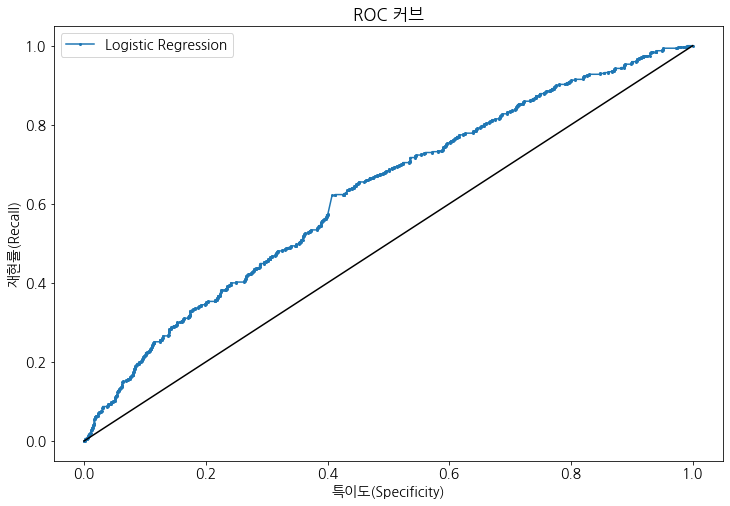

AUC :0.6259620453347391


In [608]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# RUC 곡선 그리기
fpr, tpr, threshold = roc_curve(y_train, log.decision_function(x_train))

plt.plot(fpr,tpr, 'o-', ms=2, label = "Logistic Regression")
plt.legend()
plt.plot([0,1], [0,1], 'k-', label = "random guess")
plt.xlabel('특이도(Specificity)')
plt.ylabel('재현률(Recall)')
plt.title('ROC 커브')
plt.show()

print('AUC :{}'.format(auc(fpr, tpr))) # 0.5에 가까울 수록 성능이 좋지 못함

In [609]:
# 모델 분석 결과
import statsmodels.api as sm

logit = sm.Logit(docs['PN'], df)
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.482440
         Iterations 6


In [610]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                     PN   No. Observations:                 3382
Model:                          Logit   Df Residuals:                     3364
Method:                           MLE   Df Model:                           17
Date:                Thu, 02 Jul 2020   Pseudo R-squ.:                 0.03399
Time:                        14:14:03   Log-Likelihood:                -1631.6
converged:                       True   LL-Null:                       -1689.0
Covariance Type:            nonrobust   LLR p-value:                 1.479e-16
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
화면, 방송기능       -1.1792      0.213     -5.541      0.000      -1.596      -0.762
로그인, 본인확인      -1.4888      0.265     -5.612      0.000      -2.009      -0.969
광고, 유튜브        -1.6986      0.273     -6.225    

In [611]:
print(np.exp(result.params)) # 회귀 계수가 오즈비의 로그값

화면, 방송기능       0.307510
로그인, 본인확인      0.225638
광고, 유튜브        0.182932
라디오 모드         0.222050
크롬, 끊김         0.247825
버퍼링1           0.269903
방송 화질          0.719975
서버 문제          0.185146
채팅             0.265858
모바일            0.521066
채팅, 업데이트       0.378486
회원가입, 인증       0.098179
방송 접속          0.090199
버퍼링2           0.358682
버퍼링3           0.088681
운영, 와이파이       0.607495
업데이트, 화면 비율    0.214473
튕기는 현상         0.179847
dtype: float64
